# Prédiction de la teneur en phosphate

** Chargement et exploration initiale des données **

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données depuis le fichier CSV
df = pd.read_csv('Forages.csv', sep=';')
# Afficher les premières lignes et les informations de base
df.head()


,Id,X,Y,Z,Teneur (%)
0,0,426218.951,5839036.034,8764.087675,7.184075
1,1,426258.951,5839036.034,8764.087675,7.184397
2,2,426298.951,5839036.034,8764.087675,7.184752
3,3,426338.951,5839036.034,8764.087675,7.185143
4,4,426378.951,5839036.034,8764.087675,7.185572


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37740 entries, 0 to 37739
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          37740 non-null  int64  
 1   X           37740 non-null  float64
 2   Y           37740 non-null  float64
 3   Z           37740 non-null  float64
 4   Teneur (%)  37740 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.4 MB


In [4]:
df.describe()

,Id,X,Y,Z,Teneur (%)
count,37740.000000,37740.000000,3.774000e+04,37740.000000,37740.000000
mean,20056.000000,426798.951000,5.839696e+06,9484.087674,7.187339
std,11588.778181,346.222245,3.924335e+02,427.088787,0.497956
min,0.000000,426218.951000,5.839036e+06,8764.087675,2.132827
25%,10027.750000,426498.951000,5.839356e+06,9124.087675,7.121168
50%,20056.000000,426798.951000,5.839696e+06,9484.087675,7.184192
75%,30084.250000,427098.951000,5.840036e+06,9844.087675,7.223062
max,40112.000000,427378.951000,5.840356e+06,10204.087670,13.456247


**Détection des doublons dans les coordonnées (X, Y, Z)**

In [5]:
colonnes_combinaison = ['X', 'Y', 'Z']

# Identifier les lignes où la combinaison des 4 colonnes est dupliquée
# `keep=False` permet de voir toutes les occurrences des doublons
doublons_combinaison = df[df.duplicated(subset=colonnes_combinaison, keep=False)]

# Compter le nombre de lignes dupliquées (la première occurrence n'est pas comptée)
nombre_doublons = df.duplicated(subset=colonnes_combinaison).sum()

if nombre_doublons > 0:
    print(f"Attention : {nombre_doublons} doublons trouvés sur la combinaison des colonnes X, Y, Z")
    print("\nVoici les lignes dupliquées :")
    # Afficher les doublons, triés pour une meilleure lisibilité
    print(doublons_combinaison.sort_values(by=colonnes_combinaison))

else:
    print("Aucune duplication n'a été trouvée pour la combinaison des colonnes X, Y, Z")


Aucune duplication n'a été trouvée pour la combinaison des colonnes X, Y, Z


In [6]:
# Supprimer la colonne Id (non informative)
df = df.drop(columns=["Id"])

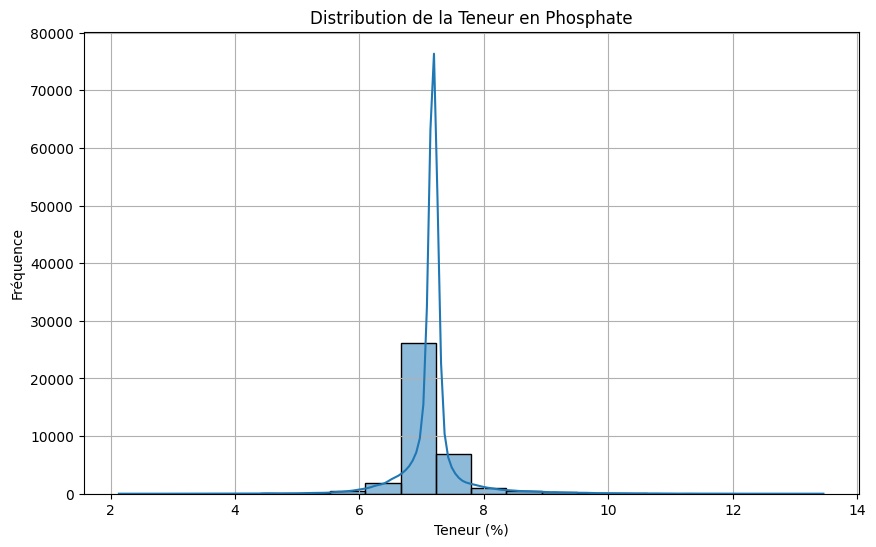

In [7]:
#Visualisation de la distribution de la Teneur (%)
plt.figure(figsize=(10, 6))
sns.histplot(df['Teneur (%)'], kde=True, bins=20)
plt.title('Distribution de la Teneur en Phosphate')
plt.xlabel('Teneur (%)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

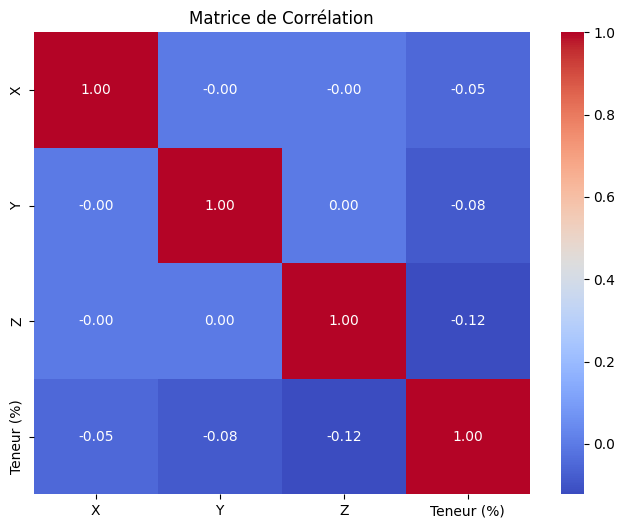

In [8]:
 #Visualisation de la matrice de corrélation
# Calcule la corrélation pour les colonnes numériques pertinentes
correlation_matrix = df[['X', 'Y', 'Z', 'Teneur (%)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation')
plt.show()

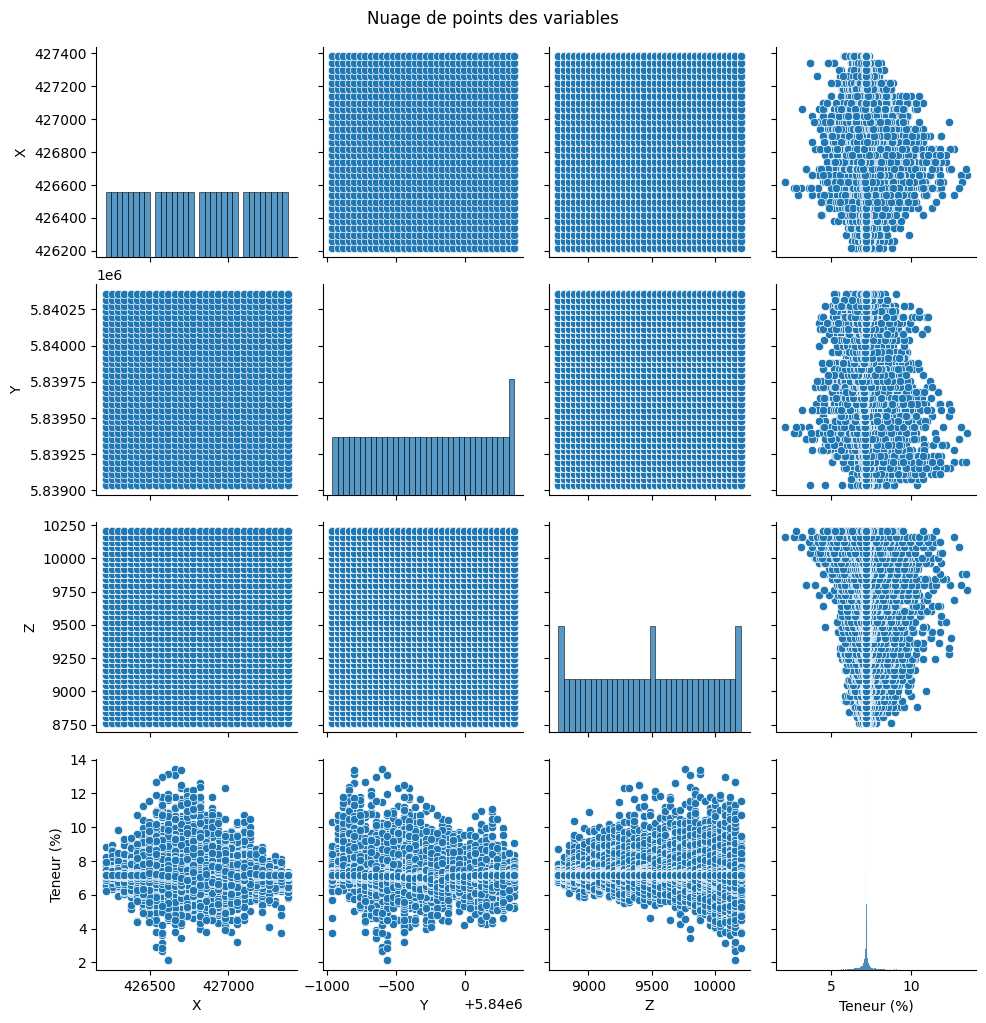

In [9]:
#Nuage de points pour visualiser la relation entre les variables
sns.pairplot(df, vars=['X', 'Y', 'Z', 'Teneur (%)'])
plt.suptitle('Nuage de points des variables', y=1.02)
plt.show()

In [3]:
# Séparer features et target
X = df[['X', 'Y', 'Z']]
y = df['Teneur (%)']

**Test 1 avec XGBOOST**


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
# Découper en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Création du modèle
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 0.4735
R²: 0.1339


=> Le modèle **ne capture pas la relation** entre les variables et la cible.

**Hypothèses possibles :**
- Les features utilisées ne sont pas pertinentes
- Le modèle n’est pas adapté (mauvais choix d’algorithme ou paramètres non optimisés.)
- Les données sont trop bruitées

**Test 2 : XGBoost avec normalisation et RandomizedSearchCV**
Pour ce test, nous allons :  
1. **Normaliser les coordonnées** X et Y, car leurs valeurs sont très grandes (~426k et 5.8M), ce qui peut gêner l’apprentissage du modèle.  
2. Utiliser **XGBoost** .  
3. Optimiser les hyperparamètres avec **RandomizedSearchCV** pour améliorer les performances.  


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import xgboost as xgb

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [9]:
param_grid = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [200, 500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='r2', verbose=2)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Évaluation
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

RMSE : 0.3749
R²   : 0.4571


=> le modèle est **moyennement performant**. Il capture partiellement la tendance, mais il reste beaucoup de variabilité non expliquée. Il faut envisager soit d’ajouter des features, soit d’utiliser un autre modèle.

**Test 3 : RandomForest avec normalisation et RandomizedSearchCV**


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [21]:
# Évaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

RMSE : 0.4235
R²   : 0.3074


=>Le problème ne vient pas du modèle mais plutôt du **dataset** :  
- Les **features disponibles (X, Y, Z)** sont insuffisantes pour capturer correctement la variabilité de la teneur.  
- Il est nécessaire d’ajouter des **features supplémentaires**

**Test 4 : Ajouter de nouvelles features et XGBoost**

In [22]:
import numpy as np
# Centrage des coordonnées
df["X_centered"] = df["X"] - df["X"].mean()   # X centré autour de sa moyenne
df["Y_centered"] = df["Y"] - df["Y"].mean()   # Y centré autour de sa moyenne

# Distance au centre (barycentre)
df["dist_center"] = (df["X_centered"]**2 + df["Y_centered"]**2)**0.5  # distance euclidienne au centre

# Interactions entre coordonnées et profondeur
df["XY"] = df["X_centered"] * df["Y_centered"]  # interaction X*Y
df["XZ"] = df["X_centered"] * df["Z"]           # interaction X*Z
df["YZ"] = df["Y_centered"] * df["Z"]           # interaction Y*Z

# Caractéristiques polynomiales (au carré)
df["X2"] = df["X_centered"]**2   # X²
df["Y2"] = df["Y_centered"]**2   # Y²
df["Z2"] = df["Z"]**2            # Z²

# Profondeur relative
df["Z_rel"] = df["Z"] - df["Z"].mean()  # différence par rapport à la profondeur moyenne

# Binning de Z
df["Z_bin"] = pd.qcut(df["Z"], q=10, labels=False)  # découpage de Z en 10 tranches

# Transformations trigonométriques (pour capter motifs spatiaux périodiques)
df["sin_X"] = np.sin(df["X_centered"] / 100)  # sinus de X
df["cos_X"] = np.cos(df["X_centered"] / 100)  # cosinus de X
df["sin_Y"] = np.sin(df["Y_centered"] / 100)  # sinus de Y
df["cos_Y"] = np.cos(df["Y_centered"] / 100)  # cosinus de Y

In [23]:
features = [col for col in df.columns if col not in ["Teneur (%)"]]
X = df[features]
y = df["Teneur (%)"]

In [24]:
# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [26]:
# Modèle XGBoost optimisé
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_model2 = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

search2 = RandomizedSearchCV(
    estimator=xgb_model2,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

search2.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [200, 500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='r2', verbose=2)

In [27]:
best_model = search2.best_estimator_

y_pred = best_model.predict(X_test)

# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

RMSE : 0.3744
R²   : 0.4585


=>Même après l'ajout des nouvelles features le modèle n'améliore pas la performance.  
Cela suggère que le **problème principal vient du dataset lui-même** : les features disponibles ne suffisent pas à capturer la variabilité de la teneur.  
Pour progresser, il faudrait envisager des **features géospatiales plus avancées**, comme la feature **IDW** ou des méthodes de **kriging** pour exploiter la structure spatiale.

**Test 5 : Ajout de la feature IDW et XGBoost**

Pour ce test, nous allons :  
1. Ajouter la **feature IDW (Inverse Distance Weighting)** au dataset :  
   - L’IDW estime la teneur d’un point en fonction des valeurs de ses **k voisins les plus proches**, pondérées par la distance.  
   - Plus un point est proche, plus son influence est grande.  
2. Ajouter quelques **features additionnelles simples** :  
   - `X_centered` et `Y_centered` → coordonnées centrées autour de leur moyenne.  
   - `dist_center` → distance euclidienne au centre des coordonnées (X, Y).  
3. Entraîner un modèle **XGBoost** sur ces features enrichies.

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors

In [29]:
# Fonction IDW
def compute_idw_feature(X_coords, y_values, k=10, power=2):
    """
    Calcule la feature IDW pour chaque point.
    X_coords : array (n,3) => colonnes [X, Y, Z]
    y_values : array (n,) => teneur
    k : nombre de voisins
    power : paramètre de pondération (2 = classique)
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_coords)
    distances, indices = neigh.kneighbors(X_coords)

    idw_preds = []
    for i, dists in enumerate(distances):
        weights = 1 / (dists ** power + 1e-12)  # éviter div/0
        weighted_avg = np.sum(weights * y_values[indices[i]]) / np.sum(weights)
        idw_preds.append(weighted_avg)
    return np.array(idw_preds)

In [30]:
# Features principales
X_coords = df[["X", "Y", "Z"]].values
y = df["Teneur (%)"].values

In [31]:
# Feature IDW
df["idw_feature"] = compute_idw_feature(X_coords, y, k=10, power=2)

# Features additionnelles
df["X_centered"] = df["X"] - df["X"].mean()
df["Y_centered"] = df["Y"] - df["Y"].mean()
df["dist_center"] = np.sqrt(df["X_centered"]**2 + df["Y_centered"]**2)


In [34]:
# Définir les features finales
features = [
    "X", "Y", "Z",       # coordonnées originales
    "idw_feature",       # estimation locale par IDW
    "X_centered",        # X centré
    "Y_centered",        # Y centré
    "dist_center"        # distance au centre
]
X = df[features]
y = df["Teneur (%)"]

In [35]:
# Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


In [37]:
# Évaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

RMSE : 0.0876
MAE  : 0.0125
R²   : 0.9703


===>L'ajout de la **feature IDW** et des coordonnées centrées a permis de capturer efficacement la **structure spatiale locale** des données.  
Le modèle XGBoost avec ces features enrichies atteint une performance très élevée et corrige largement les problèmes observés dans les tests précédents.

**Sauvegarde du modèle XGBoost au format .pkl**


In [38]:
import joblib

model_filename = "xgb_model_test5.pkl"

# Enregistrement du modèle
joblib.dump(xgb_model, model_filename)
print(f"Modèle enregistré sous : {model_filename}")

Modèle enregistré sous : xgb_model_test5.pkl
